In [195]:
import itertools
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.cluster.bicluster import SpectralBiclustering
from sklearn.cluster import AffinityPropagation, DBSCAN
import sklearn.metrics.pairwise
sns.set_style('white')
plt.rcParams['image.cmap'] = 'viridis'
%matplotlib inline

In [175]:
PROPERTY_NAMES = ['Salt', 'Rostad', 'Flottig', 'Knaprig']
generate_palette = lambda n: sns.color_palette("Set1", n_colors=n, desat=.8)
MARKERS = ['o', 'v', 's', 'p', '^', 'h', '<']

In [265]:
def plot_pairs(data, max_cols=3, clusters=None):
    data = pd.DataFrame(data)
    colnames = data.columns
    rows = int(np.ceil(len(colnames) / max_cols))
    cols = min(max_cols, len(colnames))
    pairs = list(itertools.combinations(colnames, 2))
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    
    if clusters is None:
        clusters = [0] * len(data)        

    if isinstance(clusters, dict):
        clusters = pd.Series(clusters)
    if not isinstance(clusters, pd.Series):
        clusters = pd.Series(data=clusters, index=data.index)
    clusters = clusters[data.index]

    colors = generate_palette(len(clusters.unique()))
    
    for (propa, propb), ax in zip(pairs, axs.flat):
        for cluster, marker, color in zip(clusters.unique(), MARKERS, colors):
            d = data[clusters == cluster]
            ax.scatter(d[propa], d[propb], marker=marker, color=color, s=40)
            ax.set_xlabel(propa)
            ax.set_ylabel(propb)
            fig.tight_layout()

def sort_scores(scores, people_clusters=None, nut_clusters=None):
    sorted_scores = scores.copy()
    if people_clusters is not None:
        assert len(people_clusters) == scores.shape[0]
        sorted_scores = sorted_scores.iloc[np.argsort(people_clusters), :]
    if nut_clusters is not None:
        assert len(nut_clusters) == scores.shape[1]
        sorted_scores = sorted_scores.iloc[:, np.argsort(nut_clusters)]
    return sorted_scores

def plot_biclustering(scores, **kwargs):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    sns.matrix.heatmap(sort_scores(scores, **kwargs), ax=ax)
    return ax

## Simulate nuts and people

In [222]:
def nut_generator(clusters):
    cluster_names = list(clusters.keys())
    while True:
        name = np.random.choice(cluster_names)
        yield (name, clusters[name] + 0.2 * np.random.random(len(properties)))

N = 15
M = 28
ng = nut_generator(
    {
        'more-is-more': [1., 1., 1., .1],
        'natural': [0., 0.1, 0.1, 0.4],
        'ok-but-too-salt': [0.8, 0.5, 0.5, .5],
        'dry-and-soft': [0.5, 0.5, 0.1, 0.2]
    }
)
nuts_clusters_data = [next(ng) for j in range(N)]
nuts_raw = (np.stack(list(zip(*nuts_clusters_data))[1]) * 5 + 1).round(2)

people_clusters_data = [next(ng) for j in range(M)]
people_raw = (np.stack(list(zip(*people_clusters_data))[1]) * 5 + 1).round()

nuts = pd.DataFrame(nuts_raw, columns=PROPERTY_NAMES, index=['N{}'.format(i+1) for i in range(len(nuts_raw))])
scores = sklearn.metrics.pairwise_distances(people_raw, nuts_raw, metric='euclidean')
scores = pd.DataFrame(
    scores,
    index=['P{:02}'.format(i) for i in range(len(people_raw))],
    columns=['J{:02}'.format(i) for i in range(len(nuts_raw))])

## Load real data

## Inspect the data

In [223]:
nuts

,Salt,Rostad,Flottig,Knaprig
N1,1.85,2.41,2.47,3.33
N2,4.25,4.08,2.06,2.22
N3,6.77,6.14,6.66,2.35
N4,1.09,1.78,2.47,3.78
N5,2.00,1.91,2.24,3.29
N6,4.10,4.32,1.70,2.30
N7,1.42,2.06,1.55,3.39
N8,5.69,3.94,3.93,3.55
N9,1.52,1.91,1.71,3.36
N10,5.20,3.65,3.75,4.50


In [224]:
scores.round(2)

,J00,J01,J02,J03,J04,J05,J06,J07,J08,J09,J10,J11,J12,J13,J14
P00,2.74,0.83,5.86,3.77,2.92,0.83,3.28,2.62,3.28,2.62,2.50,3.31,2.94,0.53,2.35
P01,4.75,3.16,3.87,5.61,4.90,3.45,5.58,0.55,5.49,1.04,0.81,5.51,0.58,3.30,1.08
P02,1.25,4.25,8.65,0.57,1.25,4.24,0.87,5.45,0.88,4.87,5.31,0.61,5.80,4.01,4.95
P03,0.72,3.16,7.88,1.31,0.39,3.22,0.83,4.63,0.67,4.27,4.55,0.92,5.06,3.12,4.17
P04,0.93,3.54,8.02,1.07,0.75,3.57,0.96,4.62,0.86,4.03,4.53,0.78,5.01,3.31,4.17
P05,1.25,4.25,8.65,0.57,1.25,4.24,0.87,5.45,0.88,4.87,5.31,0.61,5.80,4.01,4.95
P06,2.74,0.83,5.86,3.77,2.92,0.83,3.28,2.62,3.28,2.62,2.50,3.31,2.94,0.53,2.35
P07,7.24,5.59,0.92,8.10,7.55,5.88,8.25,4.02,8.16,4.79,3.87,8.19,3.70,6.06,4.04
P08,3.02,0.35,5.84,4.10,3.18,0.54,3.54,3.00,3.53,3.30,2.90,3.64,3.34,1.02,2.74
P09,1.10,3.94,8.52,0.94,1.07,3.95,0.73,5.46,0.70,5.07,5.33,0.78,5.85,3.85,4.95


## Compute principal components

In [225]:
pc_names = ['PC{}'.format(i + 1) for i in range(len(PROPERTY_NAMES))]
pcs = pd.DataFrame(
    sklearn.decomposition.PCA().fit_transform(nuts[PROPERTY_NAMES]),
    columns=pc_names,
    index=nuts.index)
for col in pcs.columns:
    nuts[col] = pcs[col]

## Eyeball the nut properties

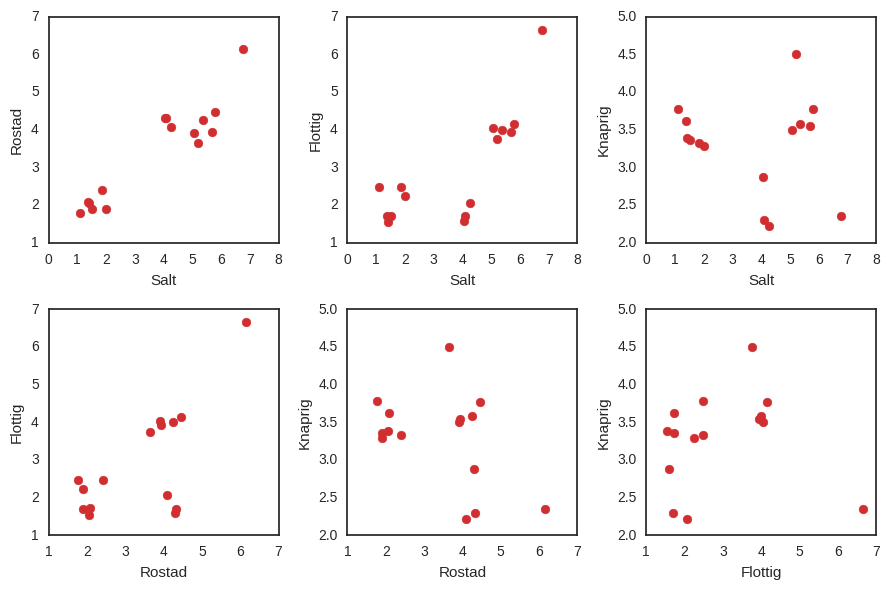

In [226]:
properties = PROPERTY_NAMES
# properties = pc_names
plot_pairs(nuts[properties])

## Try to find clusters of nut properties

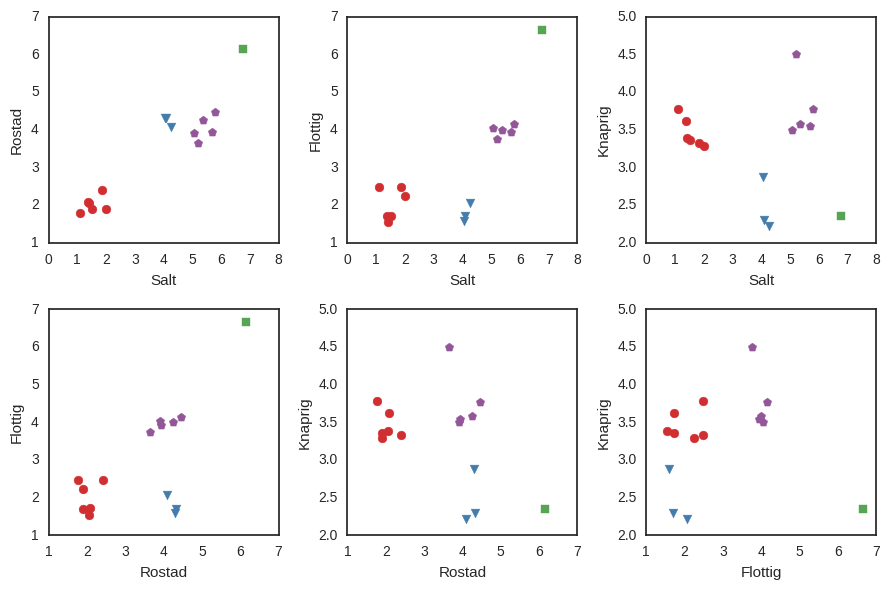

In [227]:
clustering_algorithm = AffinityPropagation()
#clustering_algorithm = DBSCAN(eps=0.3, min_samples=3)

clustering_algorithm.fit(nuts[properties])
clusters = clustering_algorithm.labels_
plot_pairs(nuts[properties], clusters=clusters)

## Try spectral biclustering

In [273]:
num_people_clusters = 4
num_nut_clusters = 4
m = SpectralBiclustering(n_clusters=(num_people_clusters, num_nut_clusters))
# m = SpectralBiclustering(n_clusters=(num_people_clusters, num_nut_clusters), method='log')
m.fit(scores)

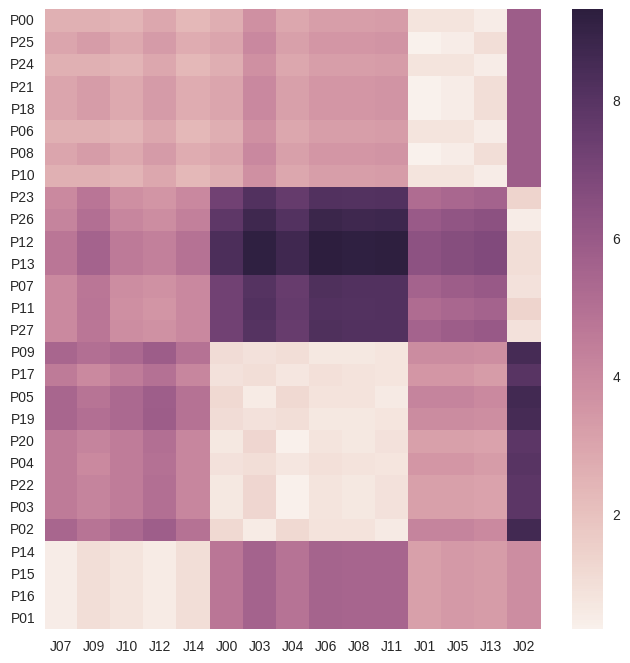

In [274]:
plot_biclustering(scores, nut_clusters=m.column_labels_, people_clusters=m.row_labels_);

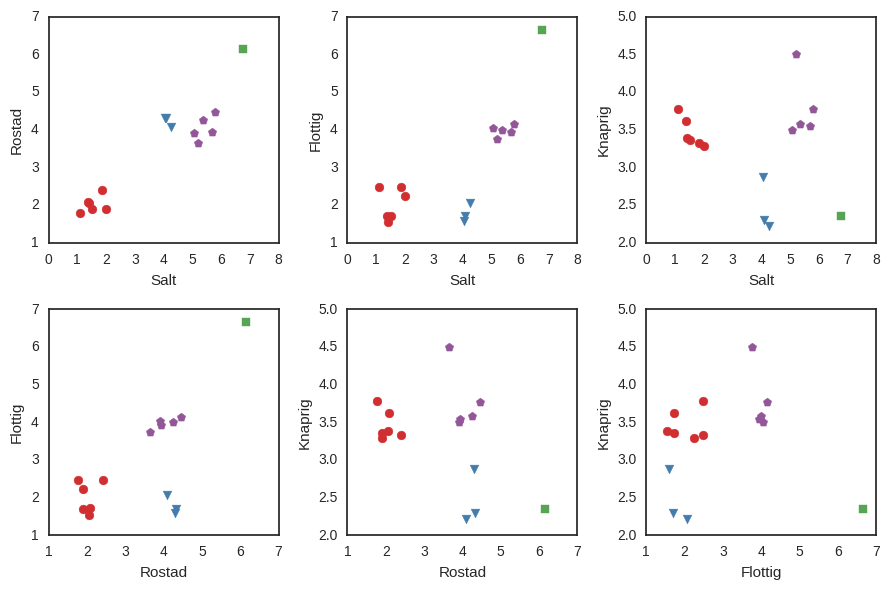

In [275]:
plot_pairs(nuts[properties], clusters=m.column_labels_)

In [16]:
def load_data(path):
    d = pd.read_csv(path, parse_dates=['Timestamp'])
    
    d = d.rename(
        columns={ ''
            'Din TBF': 'TBF',
            'Vilken jordnöt?': 'Nöt',
            'Betygsätt totalupplevelsen': 'Betyg'
        })

    nuts = ['{}{:02}'.format(v[0], int(v[1:])) for v in d['Nöt']]
    d['Nöt'] = nuts
    
    def get_latest(d):
        return d.sort_values('Timestamp', ascending=False).iloc[0]

    
    return d.groupby(['TBF', 'Nöt']).apply(get_latest).reset_index(drop=True)

In [17]:
d = load_data('Untitled form.csv')

In [18]:
d

,Timestamp,TBF,Nöt,Salt,Knaprig,Rostad,Flottig,Betyg,Kommentar
0,2016-09-17 00:24:13,ATG,J07,1,1,1,1,1,aoeu
1,2016-09-17 00:23:34,ATG,J11,3,5,3,6,4,NaN
2,2016-09-17 00:19:11,PPA,J06,6,4,5,3,5,NaN
3,2016-09-17 00:11:19,PSI,J02,3,6,3,6,1,NaN
4,2016-09-17 00:13:04,PSI,J08,5,2,5,3,7,NaN
5,2016-09-17 00:22:38,PSI,J12,4,5,5,7,6,Tjo
6,2016-09-17 00:10:46,PSI,J16,3,5,4,4,6,NaN
7,2016-09-17 00:22:04,PSI,J20,4,2,5,3,5,Bästa nöten ever!
8,2016-10-20 20:15:47,VPK,J16,6,3,5,3,5,NaN


In [41]:
properties = d.groupby('Nöt')[PROPERTY_NAMES].mean()
properties

,Salt,Knaprig,Rostad,Flottig
Nöt,,,,
J02,3,6,3,6
J06,6,4,5,3
J07,1,1,1,1
J08,5,2,5,3
J11,3,5,3,6
J12,4,5,5,7
J16,6,3,5,3
J20,4,2,5,3


In [42]:
scores = d.set_index(['TBF', 'Nöt'])['Betyg'].unstack()

In [43]:
scores

Nöt,J02,J06,J07,J08,J11,J12,J16,J20
TBF,,,,,,,,
ATG,NaN,NaN,1.0,NaN,4.0,NaN,NaN,NaN
PPA,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN
PSI,1.0,NaN,NaN,7.0,NaN,6.0,5.0,5.0


In [44]:
r = scores.loc['ATG']
r.where(r.notnull(), scores.mean())

Nöt
J02    1.0
J06    5.0
J07    1.0
J08    7.0
J11    4.0
J12    6.0
J16    5.0
J20    5.0
Name: ATG, dtype: float64

In [45]:
scores_filled = scores.apply(lambda row: row.where(row.notnull(), scores.mean()), axis=1)

In [46]:
fit_model(scores_filled, (2, 2))

SpectralBiclustering(init='k-means++', method='log', mini_batch=False,
           n_best=3, n_clusters=(2, 2), n_components=6, n_init=10,
           n_jobs=1, n_svd_vecs=None, random_state=0,
           svd_method='randomized')

In [48]:
from sklearn.cluster import DBSCAN

In [52]:
nuts* 4 + 2

,salt,roast,grease,crunch
N1,4.984916,4.564317,3.021682,2.863150
N2,6.027777,4.612461,4.196350,4.274247
N3,5.495006,5.159633,4.633630,4.826412
N4,7.025699,6.991881,6.064129,3.134063
N5,4.661332,4.673908,2.895469,3.551645
N6,3.033350,2.826139,2.679336,3.761507
N7,5.634497,4.971045,4.808410,4.946949
N8,2.220344,2.555986,2.616229,4.580098
N9,6.029088,5.167341,5.186412,5.148732
N10,4.631915,5.132121,2.908925,2.866173


In [71]:
DBSCAN?

In [83]:
import sklearn.metrics.pairwise
sklearn.metrics.pairwise.distance_metrics?

In [2]:
from sklearn.cluster import AffinityPropagation

In [104]:
np.array(list(clusters.values())) * 4 + 2

array([[ 6. ,  6. ,  6. ,  2.4],
       [ 2. ,  2.4,  2.4,  3.6],
       [ 4. ,  4. ,  2.4,  2.8],
       [ 5.2,  4. ,  4. ,  4. ]])

In [105]:
AffinityPropagation?

In [8]:
af = AffinityPropagation().fit(nuts[properties + ['k']] * 4 + 2)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)
af.cluster_centers_

array([[ 2.41398738,  3.11446003,  2.871575  ,  3.6735677 ,  6.        ],
       [ 2.35234261,  2.97155296,  2.75317612,  3.80787075,  2.        ],
       [ 4.11838558,  4.21990462,  3.10726838,  3.50725495,  2.        ],
       [ 6.52529697,  6.46434301,  6.05567091,  2.67411975,  2.        ],
       [ 5.78282839,  4.28917816,  4.34553186,  4.38590671,  2.        ]])

In [117]:
nuts['category'] = af.labels_

In [70]:
af = AffinityPropagation().fit(nuts[properties + ['k']] * 4 + 2)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)
af.cluster_centers_
db = DBSCAN(eps=1.5, min_samples=3).fit(nuts* 4 + 2)
#core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
#core_samples_mask[db.core_sample_indices_] = True
#labels = db.labels_
db.labels_

array([ 0,  1,  1, -1,  0,  2,  1,  2,  1,  0,  2,  0, -1,  1,  2])